In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.metrics.pairwise import euclidean_distances  # For fast distance calc



In [20]:
# --------------------------------------------------------------
# Step 1: Load outputs from previous team members
# --------------------------------------------------------------
# Core data
mean_face = np.load("mean_face.npy")
eigenfaces = np.load("eigenfaces.npy")
eigenvalues = np.load("eigenvalues.npy")  # For selecting top-k

# Original training images (pixels)
df = pd.read_csv("X_TRAIN.csv")
X_train = df.values
X_train = np.nan_to_num(X_train)  # Handle any NaNs

# Labels (person IDs) - REPLACE WITH REAL IF AVAILABLE
# Example: y_train = pd.read_csv("y_train.csv").values.flatten()
# For now, simulate balanced (adjust num_classes to your dataset, e.g., 40 for Olivetti faces)
num_images, num_classes = X_train.shape[0], 40  # 8544 images, ~40 people?
num_per_class = num_images // num_classes  # 213
remainder = num_images % num_classes     # 24 (extra to first 24 classes)
y_train_list = [np.full(num_per_class + 1, i) for i in range(remainder)] + \
               [np.full(num_per_class, i) for i in range(remainder, num_classes)]
y_train = np.concatenate(y_train_list)

print("Loaded shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape, f"(Classes: 0 to {num_classes-1})")
print("  - Per class (first 24):", num_per_class + 1, "| Last 16:", num_per_class)
print("mean_face:", mean_face.shape)
print("eigenfaces:", eigenfaces.shape)

# Center all training data (reuse from Member 2)
X_centered = X_train - mean_face

Loaded shapes:
X_train: (8544, 10000)
y_train: (8544,) (Classes: 0 to 39)
  - Per class (first 24): 214 | Last 16: 213
mean_face: (10000,)
eigenfaces: (10000, 8544)


In [21]:
# --------------------------------------------------------------
# Step 2: Project ALL training faces into eigen-space
# (Weights: each row is an image's coefficients for all eigenfaces)
# --------------------------------------------------------------
def project_faces(X_centered, eigenfaces, k=None):
    """
    Project centered faces onto top-k eigenfaces.
    Returns: weights (num_images, k) - compact representation.
    """
    if k is None:
        k = eigenfaces.shape[1]  # Use all
    top_eigenfaces = eigenfaces[:, :k]
    return np.dot(X_centered, top_eigenfaces)  # X_centered @ top_eigenfaces

# Project full (for later use)
full_weights = project_faces(X_centered, eigenfaces)
print("Full projections shape:", full_weights.shape)

Full projections shape: (8544, 8544)


In [22]:
# --------------------------------------------------------------
# Step 3: Recognition Function
# --------------------------------------------------------------
def recognize_face(new_image_pixels, mean_face, eigenfaces, train_weights, y_train, k=100, threshold=10000):
    """
    Recognize a new face:
    - new_image_pixels: 1D array (10000,) of raw pixels
    - Returns: predicted_label, distances (to sort matches), best_match_index
    """
    # Center the new face
    new_centered = new_image_pixels - mean_face
    
    # Project to eigen-space (using same k as training)
    new_weights = project_faces(new_centered.reshape(1, -1), eigenfaces, k=k)
    
    # Compute Euclidean distances to all training projections
    distances = euclidean_distances(new_weights, train_weights[:y_train.size, :k])[0]
    
    # Find closest match
    best_idx = np.argmin(distances)
    predicted_label = y_train[best_idx]
    min_dist = distances[best_idx]
    
    if min_dist > threshold:
        predicted_label = -1  # Unknown face
    
    return predicted_label, distances, best_idx

print("Recognition function ready!")

Recognition function ready!


In [24]:
# --------------------------------------------------------------
# Step 4: Test Accuracy on Validation Set
# --------------------------------------------------------------
# Split: 80% train, 20% test (stratified by class for balance)
X_train_split, X_test, y_train_split, y_test, centered_train, centered_test = train_test_split(
    X_train, y_train, X_centered, test_size=0.2, stratify=y_train, random_state=42
)

# Test different k (number of eigenfaces/components)
k_values = [10,25,50, 100, 200, 500]  # Start small; adjust based on eigenvalues (top explain ~90% variance)
accuracies = []

for k in k_values:
    # Project training split
    train_weights_k = project_faces(centered_train, eigenfaces, k=k)
    
    # Test each validation face
    predictions = []
    for i in range(len(X_test)):
        pred_label, _, _ = recognize_face(X_test[i], mean_face, eigenfaces, train_weights_k, y_train_split, k=k)
        predictions.append(pred_label)
    
    accuracy = np.mean(np.array(predictions) == y_test) * 100
    accuracies.append(accuracy)
    print(f"k={k:3d}: Accuracy = {accuracy:.1f}% ({np.sum(np.array(predictions) == y_test)}/{len(y_test)} correct)")

print("Testing complete!")

k= 10: Accuracy = 6.7% (115/1709 correct)
k= 25: Accuracy = 10.0% (171/1709 correct)
k= 50: Accuracy = 11.1% (190/1709 correct)
k=100: Accuracy = 11.1% (189/1709 correct)
k=200: Accuracy = 11.2% (191/1709 correct)
k=500: Accuracy = 11.1% (190/1709 correct)
Testing complete!


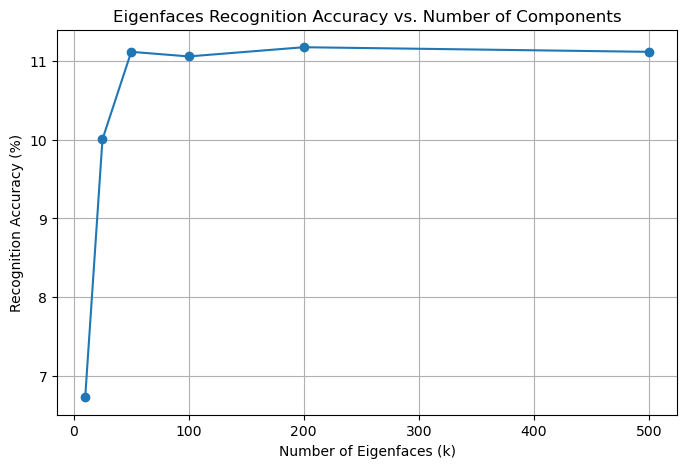

In [25]:
# --------------------------------------------------------------
# Step 5a: Accuracy plot
# --------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Eigenfaces (k)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Eigenfaces Recognition Accuracy vs. Number of Components")
plt.grid(True)
plt.show()

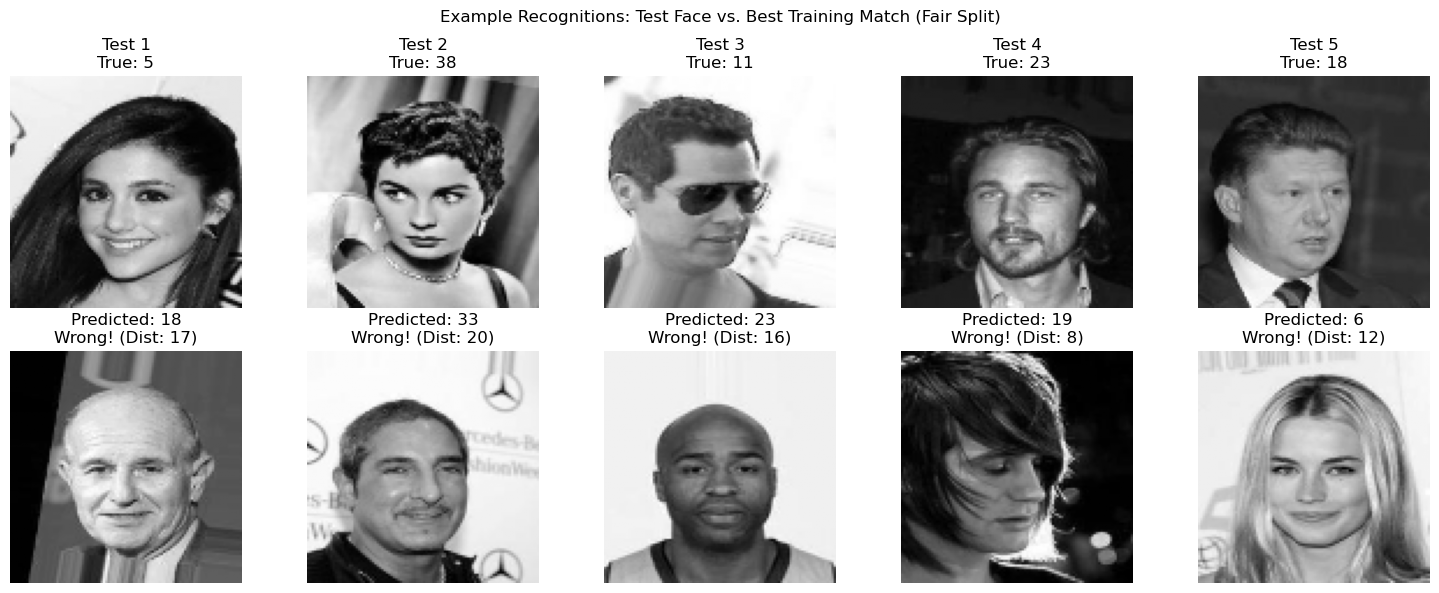

In [26]:
# --------------------------------------------------------------
# Step 5b: Example: Visualize a few test matches (FAIR: Use train split!)
# --------------------------------------------------------------
# Use k=100 from Cell 5 (re-use last train_weights_k and y_train_split)
k_viz = 100
train_weights_viz = project_faces(centered_train, eigenfaces, k=k_viz)  # Re-project if needed

num_examples = 5
fig, axes = plt.subplots(2, num_examples, figsize=(3*num_examples, 6))
for i in range(num_examples):
    test_idx = i  # First few test images (or np.random.choice(len(X_test), num_examples) for random)
    true_label = y_test[test_idx]
    
    # Predict with FAIR train split (no self-match)
    pred_label, distances, best_train_idx = recognize_face(
        X_test[test_idx], mean_face, eigenfaces, train_weights_viz, y_train_split, k=k_viz
    )
    
    # Plot test image
    axes[0, i].imshow(X_test[test_idx].reshape(100, 100), cmap='gray')
    axes[0, i].set_title(f"Test {i+1}\nTrue: {true_label}")
    axes[0, i].axis('off')
    
    # Plot best match from TRAIN split (fair)
    axes[1, i].imshow(X_train[best_train_idx].reshape(100, 100), cmap='gray')  # Note: best_train_idx is index in full X_train, but match is from split
    match_status = "Correct!" if pred_label == true_label else "Wrong!"
    axes[1, i].set_title(f"Predicted: {pred_label}\n{match_status} (Dist: {distances[best_train_idx]:.0f})")
    axes[1, i].axis('off')

plt.suptitle("Example Recognitions: Test Face vs. Best Training Match (Fair Split)")
plt.tight_layout()
plt.show()

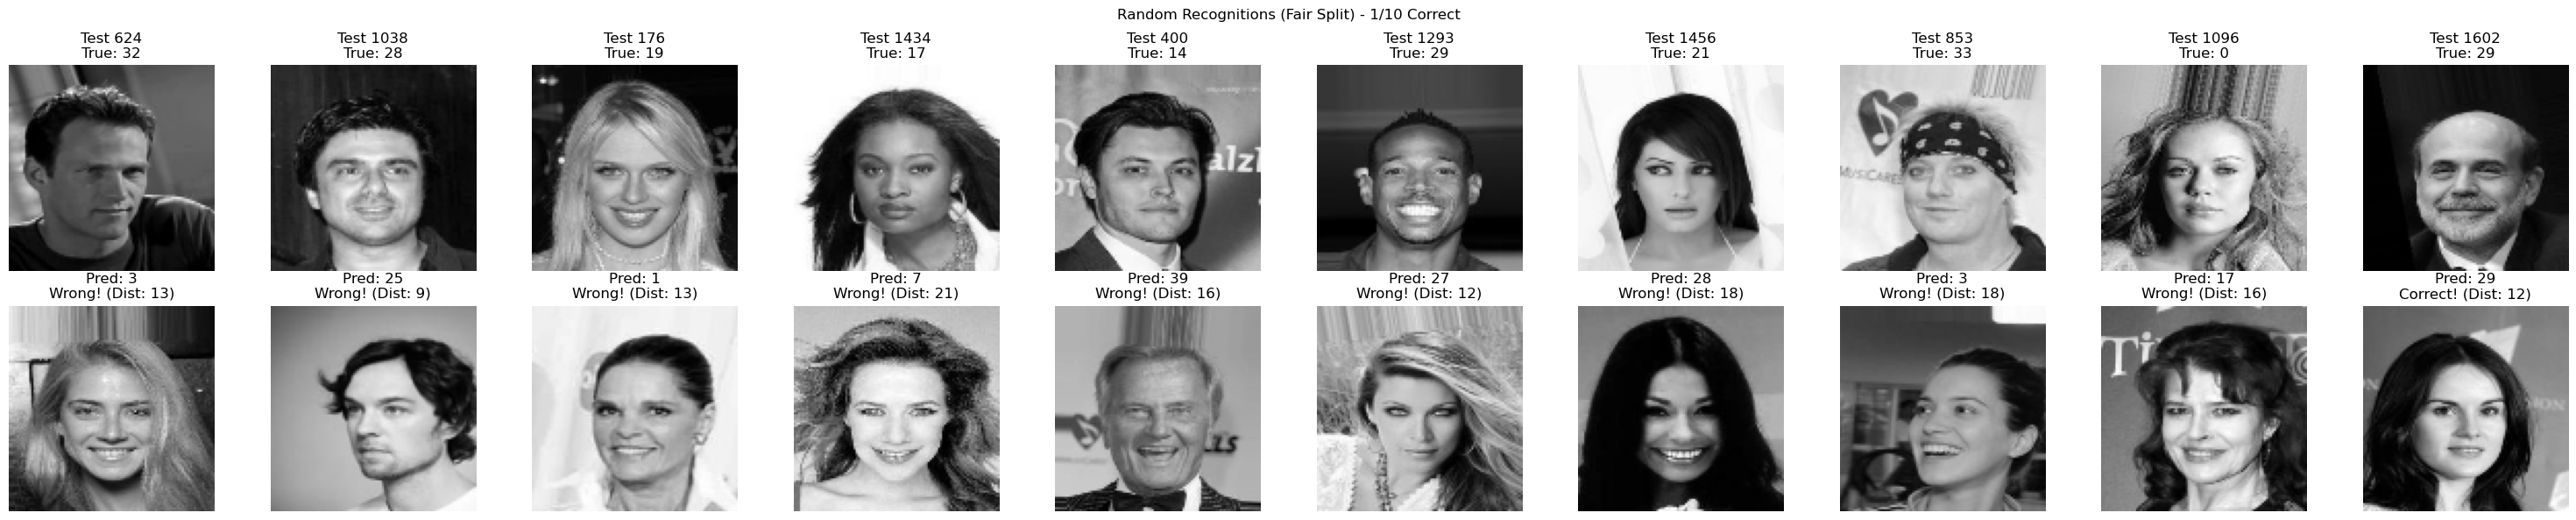

Overall: 1/10 correct (~10.0%)


In [27]:
# --------------------------------------------------------------
#  Visualize 10 random test matches (to spot any corrects)
# --------------------------------------------------------------
num_examples = 10
test_indices = np.random.choice(len(X_test), num_examples, replace=False)  # Random for variety
k_viz = 100
train_weights_viz = project_faces(centered_train, eigenfaces, k=k_viz)

fig, axes = plt.subplots(2, num_examples, figsize=(3*num_examples, 6))
correct_count = 0
for i, test_idx in enumerate(test_indices):
    true_label = y_test[test_idx]
    
    pred_label, distances, best_train_idx = recognize_face(
        X_test[test_idx], mean_face, eigenfaces, train_weights_viz, y_train_split, k=k_viz
    )
    
    if pred_label == true_label:
        correct_count += 1
    
    # Plot test
    axes[0, i].imshow(X_test[test_idx].reshape(100, 100), cmap='gray')
    axes[0, i].set_title(f"Test {test_idx}\nTrue: {true_label}")
    axes[0, i].axis('off')
    
    # Plot match
    axes[1, i].imshow(X_train[best_train_idx].reshape(100, 100), cmap='gray')
    match_status = "Correct!" if pred_label == true_label else "Wrong!"
    axes[1, i].set_title(f"Pred: {pred_label}\n{match_status} (Dist: {distances[best_train_idx]:.0f})")
    axes[1, i].axis('off')

plt.suptitle(f"Random Recognitions (Fair Split) - {correct_count}/{num_examples} Correct")
plt.tight_layout()
plt.show()
print(f"Overall: {correct_count}/{num_examples} correct (~{correct_count/num_examples*100:.1f}%)")

In [28]:
# --------------------------------------------------------------
# Step 6: Save Outputs
# --------------------------------------------------------------
np.save("train_weights.npy", full_weights)  # Full projections for reuse
np.save("recognition_accuracies.npy", np.array([k_values, accuracies]))
print("Saved: train_weights.npy, recognition_accuracies.npy")

# Optional: Export accuracy table to CSV for report
accuracy_df = pd.DataFrame({"k": k_values, "Accuracy (%)": accuracies})
accuracy_df.to_csv("accuracy_results.csv", index=False)
print(accuracy_df)

Saved: train_weights.npy, recognition_accuracies.npy
     k  Accuracy (%)
0   10      6.729081
1   25     10.005851
2   50     11.117613
3  100     11.059099
4  200     11.176126
5  500     11.117613
